# Лабораторная работа 12-14.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import precision_score, recall_score, accuracy_score, multilabel_confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.datasets import fetch_openml, fetch_20newsgroups
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from scipy.stats import zscore, uniform

from ucimlrepo import fetch_ucirepo 

## Задача 1. Классификация изображений рукописных цифр.
+ Набор данных: MNIST.
+ Предварительная обработка: масштабирование пикселей, разделение данных на обучение и тестирование.
+ Модели: логистическая регрессия, SVM, случайный лес, градиентный бустинг, нейронные сети.
+ Сравнение модели: точность, матрица ошибок, ROC-кривые.
+ Изучение и подбор гиперпараметров: GridSearchCV или RandomizedSearchCV.
+ Визуализация: отображение изображений, важности признаков или активаций нейронной сети.


In [2]:
ds_mnist = fetch_openml('mnist_784', version=1)

X, y = ds_mnist.data, ds_mnist.target

In [3]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X, y)

In [4]:
def function(models, X, y,
             multiclass=False, is_accuracy=True, is_precision=True, is_recall=True, 
             is_confusion_matrix=True, is_randomSearch=True, is_roc_curve=True, is_feature_importances=True):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    for model in models:
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        print(model)

        if is_accuracy:
            print(f'Accuracy: {accuracy_score(y_test, y_pred)}')

        if is_precision:
            print(f'Precision: {precision_score(y_test, y_pred, average='weighted')}')

        if is_recall:
            print(f'Recall: {recall_score(y_test, y_pred, average='weighted')}')

        if is_confusion_matrix:
            print(f'Матрица ошибок: {multilabel_confusion_matrix(y_test, y_pred)}')

        if is_randomSearch:
            if isinstance(model, LogisticRegression):
                param = {
                        'max_iter' : [100, 200],
                        'warm_start' : [True, False],
                        'solver' : ['lbfgs', 'newton-cg', 'liblinear'],
                        'C' : [0.01, 0.05, 0.1, 1],
                }
            elif isinstance(model, SVC):
                param = {
                        'C': [0.1, 1],
                        'gamma': ['auto']
                    }
            elif isinstance(model, DecisionTreeClassifier):
                param = {'max_depth': [3, 5]}
            elif isinstance(model, RandomForestClassifier):
                param = {'n_estimators': [50, 100, 150]}
            elif isinstance(model, GradientBoostingClassifier):
                param = {'learning_rate': [0.01, 0.1, 0.5]}
            elif isinstance(model, MLPClassifier):
                param = {
                        'hidden_layer_sizes': [(50,), (100,)],
                        'activation': ['relu'],
                        'learning_rate_init': [0.01, 0.1],
                        'alpha': [0.01, 0.1]
                    }
            elif isinstance(model, KNeighborsClassifier):
                n_neighbors = [3, 4]
                weights = ['distance']
                algorithm = ['auto']
                param = dict(n_neighbors = n_neighbors , weights = weights ,algorithm = algorithm )

            random_search = RandomizedSearchCV(estimator = model, param_distributions=param, scoring = 'accuracy', cv = 5, verbose=0)

            random_search.fit(X_train, y_train)   

            print('Лучшие параметры RandomSearchCV: ', random_search.best_params_)
            print('Лучший результат для RandomSearchCV: ', random_search.best_score_)

        if multiclass == False:
            if is_roc_curve:
                fpr, tpr, thresholds = roc_curve(y_test, y_pred)
                roc =auc(fpr,tpr)

                plt.figure(figsize=(15, 6))
                plt.title('ROC-кривая')

                lw = 2

                plt.plot(fpr, tpr, color='darkorange', lw=lw, label=f'ROC curve (area = {roc})')
                plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
                plt.xlabel('FP-rate')
                plt.ylabel('TP-rate')
                plt.legend()
                plt.show()

        if is_feature_importances:
            if hasattr(model, 'feature_importances_'):
                feature_importance = model.feature_importances_
                print('Feature Importance:')
                for i, importance in enumerate(feature_importance):
                    print(f'{X_train.columns[i]}: {importance}')    
                
                plt.figure(figsize=(12, 6))
                plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
                plt.xticks(range(len(X_train.columns)), X_train.columns, rotation=45)
                plt.xlabel('Признаки')
                plt.ylabel('Важность')
                plt.title('Важность признаков')
                plt.show()

        print('------------------------------------------------------------------------------------------------')

In [ ]:
models = [LogisticRegression(), SVC(), RandomForestClassifier(), DecisionTreeClassifier(), MLPClassifier()]

function(models, X_scaled, y, multiclass=True, is_feature_importances=False)

LogisticRegression()
Accuracy: 0.9211428571428572
Precision: 0.9210238176872289
Recall: 0.9211428571428572
Матрица ошибок: [[[12611    46]
  [   52  1291]]

 [[12315    85]
  [   48  1552]]

 [[12504   116]
  [  146  1234]]

 [[12432   135]
  [  148  1285]]

 [[12596   109]
  [   91  1204]]

 [[12562   165]
  [  143  1130]]

 [[12531    73]
  [   62  1334]]

 [[12383   114]
  [   85  1418]]

 [[12512   131]
  [  171  1186]]

 [[12450   130]
  [  158  1262]]]
Лучшие параметры RandomSearchCV:  {'warm_start': False, 'solver': 'lbfgs', 'max_iter': 200, 'C': 0.05}
Лучший результат для RandomSearchCV:  0.9201607142857144
------------------------------------------------------------------------------------------------
SVC()
Accuracy: 0.9764285714285714
Precision: 0.9764205434434183
Recall: 0.9764285714285714
Матрица ошибок: [[[12644    13]
  [   14  1329]]

 [[12372    28]
  [   15  1585]]

 [[12576    44]
  [   32  1348]]

 [[12526    41]
  [   47  1386]]

 [[12668    37]
  [   26  1269]]

 [

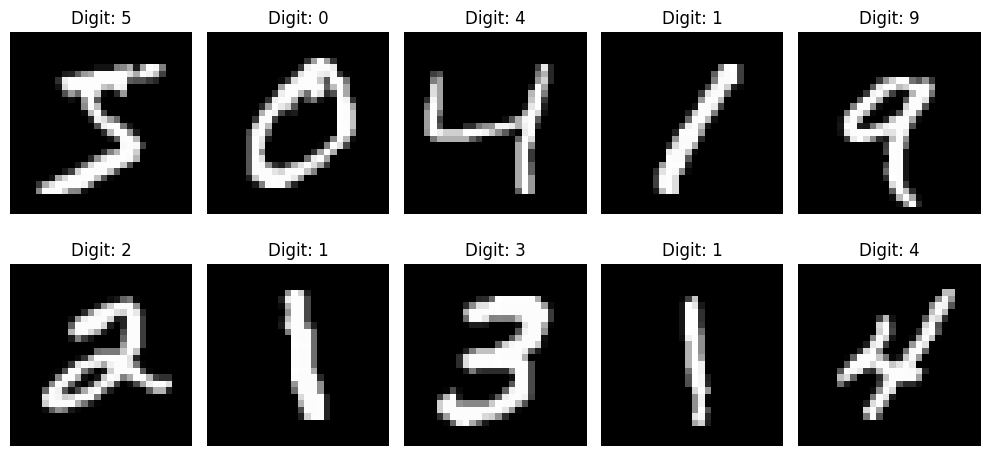

In [ ]:
images = X.values.reshape(-1, 28, 28)

plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title(f'Digit: {y[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

## Задача 2. Определение мошенничества с кредитными картами.

+ Набор данных: Credit Card Fraud Detection dataset на Kaggle.
+ Предварительная обработка: масштабирование, обработка несбалансированных данных.
+ Модели: логистическая регрессия, SVM, случайный лес, градиентный бустинг, нейронные сети.
+ Сравнение моделей: точность, полнота, ROC-кривые.
+ Изучение и подбор гиперпараметров: GridSearchCV или RandomizedSearchCV.
+ Визуализация: важности признаков, ROC-кривые.


In [ ]:
df_credit = pd.read_csv(r'Datasets\creditcard.zip')

df_credit = df_credit.sample(3000)

df_credit.head(7)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
200637,133513.0,-2.027337,1.296591,1.005680,-0.807739,-0.661203,1.167174,-1.685949,-5.100305,-0.114841,-1.822907,-1.911701,-0.098956,-0.752224,0.432101,0.050631,0.862534,-0.425649,0.501397,-0.394907,1.196234,-2.454976,1.328418,-0.285200,-0.537550,0.515599,0.892243,0.304407,0.117383,127.50,0
281433,170179.0,1.998192,0.250232,-2.321998,0.723998,0.627333,-0.833688,0.119003,-0.133567,0.496274,-0.896927,1.084985,0.439022,-0.329775,-2.448225,-1.011854,0.592178,1.702775,1.164015,0.094507,-0.132160,0.013989,0.341881,-0.101070,-0.605463,0.210532,0.736788,-0.038463,-0.026525,10.70,0
178093,123472.0,2.075350,-0.055095,-1.421226,0.272513,0.366306,-0.576490,0.224392,-0.277972,0.462633,0.021689,-0.979460,0.753389,0.913542,0.045093,-0.248821,-0.183304,-0.371336,-0.859402,0.325751,-0.115290,-0.260003,-0.593082,0.262723,0.510334,-0.109061,0.255254,-0.074965,-0.055808,12.83,0
228249,145419.0,1.732801,-0.547195,-0.263204,1.315622,-0.753534,-0.202484,-0.556197,0.148779,0.818048,0.382001,0.684242,0.323739,-1.217922,0.477374,0.264093,0.642619,-0.879027,0.893935,-0.595847,-0.152478,0.325768,0.810860,0.081649,-0.027336,-0.219387,-0.586301,0.032012,-0.027260,92.58,0
30992,36167.0,1.387969,-0.556594,0.363600,-0.852808,-0.954918,-0.599956,-0.675466,0.024212,-0.875707,0.817267,1.024215,-0.608986,-1.089306,0.306529,0.235069,1.550732,-0.063180,-0.900661,1.072078,0.012153,-0.121542,-0.577618,0.112832,-0.055475,0.195386,-0.509805,-0.006315,0.005971,10.15,0
31867,36545.0,-0.405475,0.063061,1.652519,0.025788,-0.603730,0.905562,0.225185,0.239638,0.208645,-0.588804,-1.200522,-0.277646,0.294678,-0.378277,1.307113,-0.147010,0.072802,0.060771,0.985857,0.390309,0.237898,0.681785,0.106390,-0.681890,-0.562598,1.248928,0.089446,0.144705,135.45,0
202864,134524.0,-2.418271,1.016602,-0.258279,-2.165342,-1.865041,0.820349,-2.749987,-4.285559,-1.549150,-1.441634,-0.282433,-0.225323,-1.840778,1.325107,-1.204848,2.444951,0.154275,-0.501493,0.057704,0.722447,-2.445751,0.631484,0.009518,-0.407696,-0.710332,-0.635111,-0.135471,-0.059336,159.90,0


In [ ]:
df_credit['Class'].value_counts()

Class
0    2995
1       5
Name: count, dtype: int64

In [ ]:
df_credit.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3000 entries, 200637 to 219262
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    3000 non-null   float64
 1   V1      3000 non-null   float64
 2   V2      3000 non-null   float64
 3   V3      3000 non-null   float64
 4   V4      3000 non-null   float64
 5   V5      3000 non-null   float64
 6   V6      3000 non-null   float64
 7   V7      3000 non-null   float64
 8   V8      3000 non-null   float64
 9   V9      3000 non-null   float64
 10  V10     3000 non-null   float64
 11  V11     3000 non-null   float64
 12  V12     3000 non-null   float64
 13  V13     3000 non-null   float64
 14  V14     3000 non-null   float64
 15  V15     3000 non-null   float64
 16  V16     3000 non-null   float64
 17  V17     3000 non-null   float64
 18  V18     3000 non-null   float64
 19  V19     3000 non-null   float64
 20  V20     3000 non-null   float64
 21  V21     3000 non-null   float64
 22

In [ ]:
df_credit.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [ ]:
df_credit.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,93741.948000,-0.076451,0.004223,-0.001610,0.057541,-0.019230,0.043865,0.031530,0.025471,0.035590,-0.014551,0.006761,-0.002637,0.005288,0.007028,0.001669,0.025887,-0.014487,0.022214,-0.014788,0.008023,-0.002874,0.015359,0.006684,0.003085,-0.000420,0.004306,-0.012688,-0.008548,97.231930,0.001667
std,48026.035464,2.038641,1.713970,1.627703,1.469825,1.527799,1.410321,1.430933,1.066730,1.112947,1.167629,1.002487,0.998244,1.020553,0.977074,0.912354,0.870738,0.855148,0.824562,0.843900,0.831745,0.710129,0.720430,0.589397,0.604163,0.526403,0.475074,0.429844,0.346830,298.189105,0.040798
min,44.000000,-26.457745,-20.495674,-30.177317,-5.560118,-22.325816,-8.439279,-31.197329,-17.140062,-9.462573,-22.187089,-4.049895,-10.592305,-3.624386,-12.457999,-3.700478,-7.787326,-12.822177,-5.501051,-4.192616,-17.118454,-8.755698,-4.471205,-7.061382,-2.163387,-3.028482,-1.395009,-7.263482,-5.954281,0.000000,0.000000
25%,52678.000000,-0.989788,-0.567984,-0.899868,-0.821048,-0.671416,-0.764741,-0.532426,-0.209253,-0.590006,-0.545514,-0.748279,-0.415724,-0.663309,-0.423006,-0.562200,-0.421466,-0.513941,-0.464860,-0.473639,-0.210709,-0.229832,-0.549295,-0.165627,-0.349959,-0.315313,-0.327538,-0.074394,-0.055325,5.407500,0.000000
50%,83305.000000,-0.030172,0.090796,0.212799,0.044780,-0.059322,-0.254418,0.036826,0.021479,-0.029993,-0.110243,-0.018860,0.173556,-0.007137,0.064212,0.045857,0.088716,-0.103163,0.013252,-0.015568,-0.065512,-0.030176,0.011916,-0.012127,0.034238,0.037346,-0.044409,-0.002044,0.011299,21.035000,0.000000
75%,139622.500000,1.286563,0.805364,1.060395,0.784821,0.620232,0.400716,0.586540,0.365193,0.603071,0.410277,0.750115,0.625842,0.687972,0.516521,0.641929,0.542240,0.374580,0.489651,0.441845,0.144743,0.194405,0.559482,0.136178,0.451729,0.335426,0.255333,0.082816,0.078272,76.000000,0.000000
max,172676.000000,2.367452,16.497472,4.017561,8.904157,22.707762,15.568823,28.069822,7.500621,7.937413,11.609216,6.029033,3.888681,3.339952,5.155076,3.065730,3.594875,6.443649,4.029395,3.833736,17.141052,17.206991,3.460893,17.768462,3.398296,3.655826,2.181908,4.250372,5.980243,7766.600000,1.000000


In [ ]:
# df_credit[df_credit.drop(columns=['Class']).columns] = df_credit[np.abs(zscore(df_credit) < 3).all(axis=1)][df_credit.drop(columns=['Class']).columns]

# df_credit.describe()

In [ ]:
df_credit['Class'].value_counts()

Class
0    2995
1       5
Name: count, dtype: int64

In [ ]:
X, y = df_credit.drop(columns=['Time', 'Amount', 'Class']), df_credit['Class']

X_scaled = MinMaxScaler().fit_transform(X, y)

LogisticRegression()
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Матрица ошибок: [[[  1   0]
  [  0 599]]

 [[599   0]
  [  0   1]]]
Лучшие параметры RandomSearchCV:  {'warm_start': True, 'solver': 'newton-cg', 'max_iter': 100, 'C': 0.05}
Лучший результат для RandomSearchCV:  0.9991666666666668


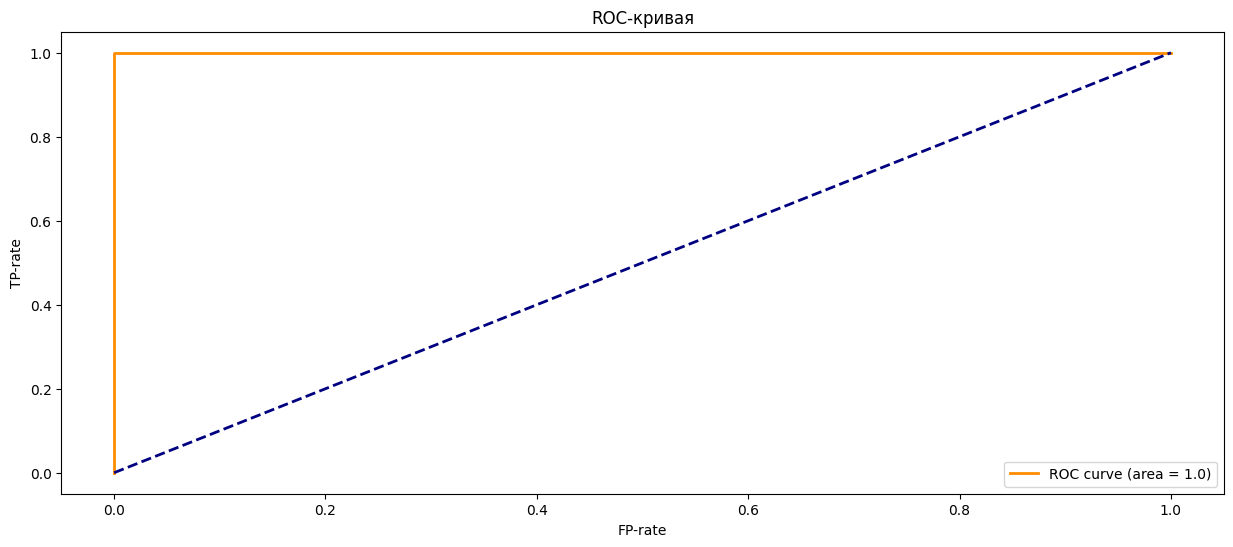

------------------------------------------------------------------------------------------------
SVC()
Accuracy: 0.9983333333333333
Precision: 0.9966694444444445
Recall: 0.9983333333333333
Матрица ошибок: [[[  0   1]
  [  0 599]]

 [[599   0]
  [  1   0]]]
Лучшие параметры RandomSearchCV:  {'gamma': 'auto', 'C': 0.1}
Лучший результат для RandomSearchCV:  0.9983333333333334


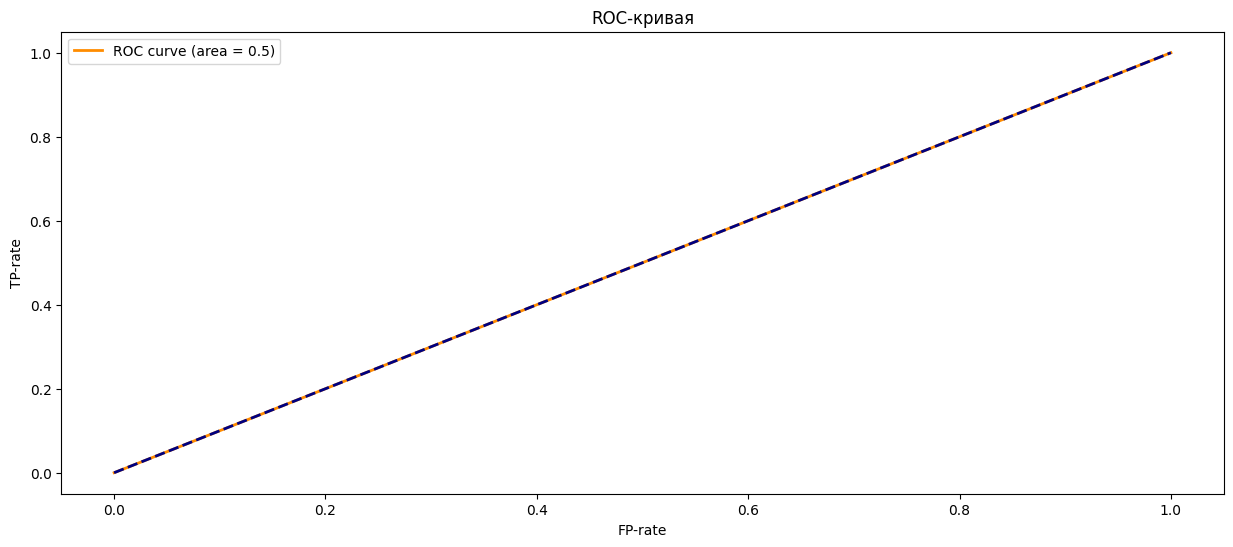

------------------------------------------------------------------------------------------------
RandomForestClassifier()
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Матрица ошибок: [[[  1   0]
  [  0 599]]

 [[599   0]
  [  0   1]]]
Лучшие параметры RandomSearchCV:  {'n_estimators': 50}
Лучший результат для RandomSearchCV:  0.99875


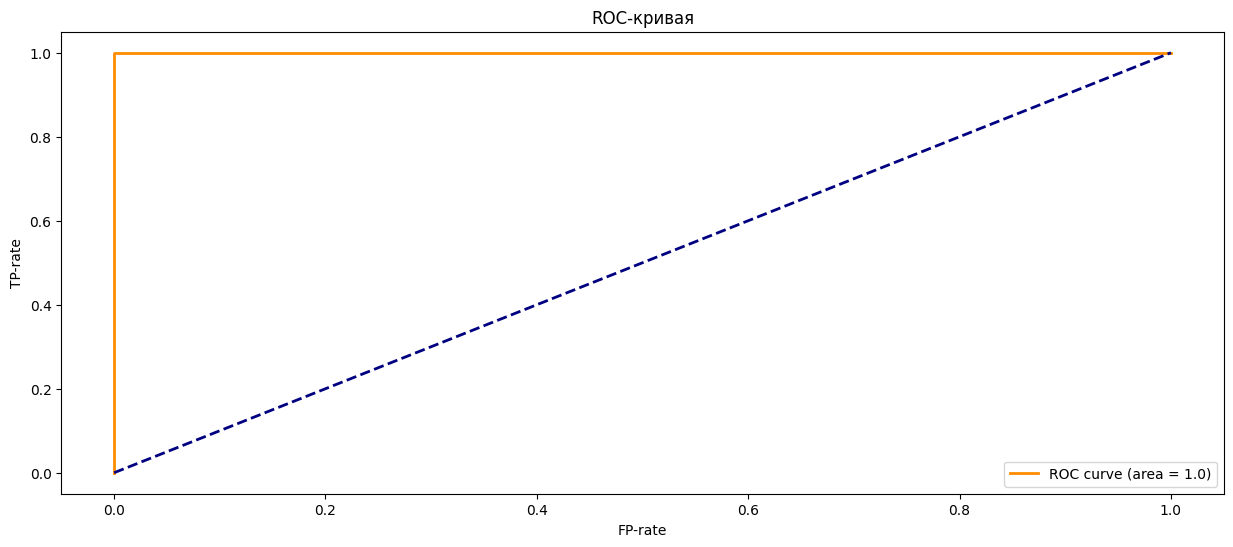

Feature Importance:
V1: 0.02615087528729277
V2: 0.027044511149700683
V3: 0.011837939515639837
V4: 0.023226754047098293
V5: 0.009584080986332575
V6: 0.005158938290499725
V7: 0.01087134872607338
V8: 0.004999607643382533
V9: 0.06308271529333052
V10: 0.058291133032499484
V11: 0.13960613933730584
V12: 0.1003709428219769
V13: 0.011924616749314406
V14: 0.1468516399214206
V15: 0.013649087124569925
V16: 0.04100285190538193
V17: 0.149061388214352
V18: 0.02842433808499662
V19: 0.06414420835698949
V20: 0.00526547736684557
V21: 0.015708708315977947
V22: 0.011784932575449249
V23: 0.012658093726456739
V24: 0.00015388801488610155
V25: 0.001720363512810289
V26: 0.0026682512593627816
V27: 0.010497630715715134
V28: 0.004259538024338881


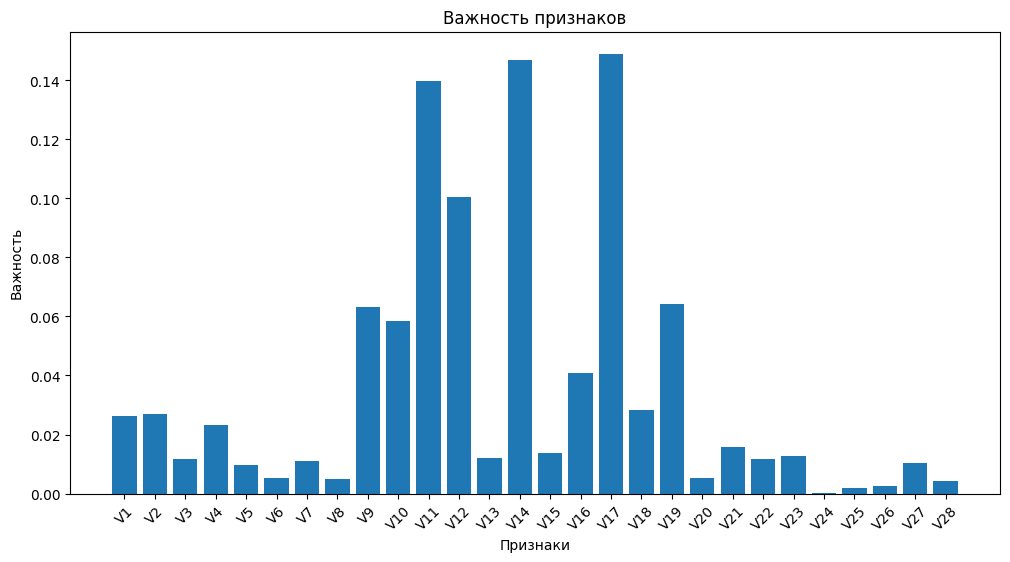

------------------------------------------------------------------------------------------------
GradientBoostingClassifier()
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Матрица ошибок: [[[  1   0]
  [  0 599]]

 [[599   0]
  [  0   1]]]
Лучшие параметры RandomSearchCV:  {'learning_rate': 0.01}
Лучший результат для RandomSearchCV:  0.9979166666666668


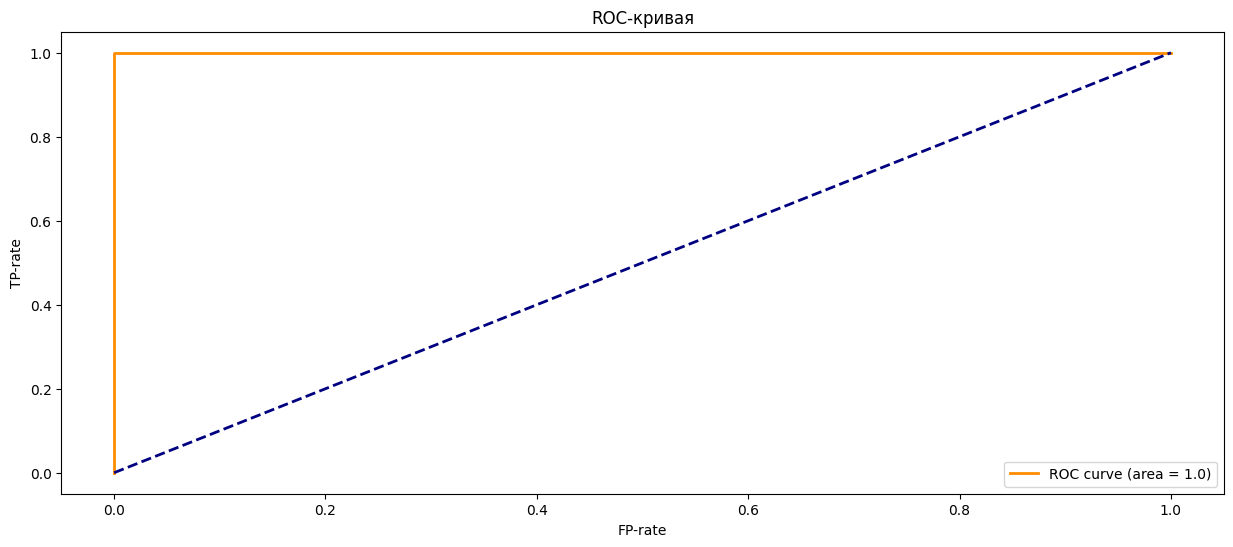

Feature Importance:
V1: 0.0
V2: 0.0
V3: 0.0
V4: 0.0
V5: 0.0
V6: 0.0
V7: 0.0
V8: 0.0
V9: 0.0
V10: 0.0
V11: 0.7496871088864714
V12: 0.0
V13: 0.0
V14: 0.0
V15: 0.0
V16: 0.0
V17: 0.25031289111352856
V18: 0.0
V19: 0.0
V20: 0.0
V21: 0.0
V22: 0.0
V23: 0.0
V24: 0.0
V25: 0.0
V26: 0.0
V27: 0.0
V28: 0.0


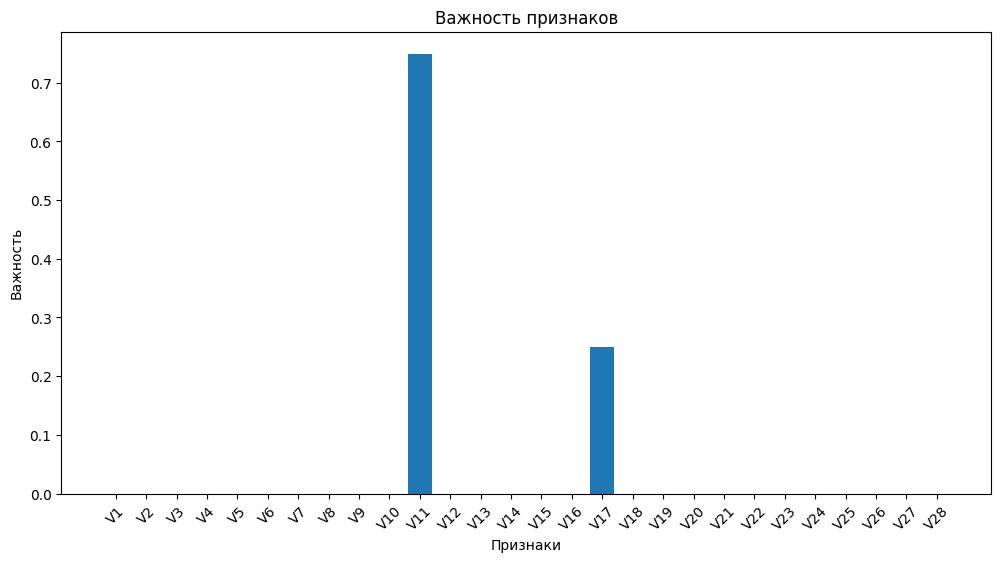

------------------------------------------------------------------------------------------------


In [ ]:
models = [LogisticRegression(), SVC(), RandomForestClassifier(), GradientBoostingClassifier()]

function(models, X, y, multiclass=False)

In [ ]:
# model = LogisticRegression()
# model.fit(X_train, y_train)

# parameters = [{'penalty':['l1','l2']}, 
#               {'C':[1, 10, 100, 1000]}]
# grid_search = GridSearchCV(estimator = model, param_grid = parameters, scoring = 'accuracy', cv = 5, verbose=0)


# grid_search.fit(X_train, y_train)   

# print(model)
# print('Лучшие параметры GridSearchCV: ', grid_search.best_params_)
# print('Лучший результат для GridSearchCV: ', grid_search.best_score_)

## Задача 3. Классификация рака молочной железы.
+ Набор данных: [Breast Cancer Wisconsin (Diagnostic)](https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data).
+ Предварительная обработка: масштабирование, разделение данные на обучающие и тестовые.
+ Модели: логистическая регрессия, SVM, решуающие деревья, случайный лес, градиентный бустинг, нейронные сети.
+ Сравнение моделей: точность, матрица ошибок, ROC-кривые.
+ Изучение и подбор гиперпараметров: GridSearchCV или RandomizedSearchCV.
+ Визуализация: важности признаков, корреляционная матрица.

In [ ]:
df_cancer = pd.read_csv(r'Datasets\cancer.zip')

df_cancer.head(7)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN
5,843786,M,12.45,15.70,82.57,477.1,0.12780,0.17000,0.1578,0.08089,0.2087,0.07613,0.3345,0.8902,2.217,27.19,0.007510,0.03345,0.03672,0.01137,0.02165,0.005082,15.47,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440,NaN
6,844359,M,18.25,19.98,119.60,1040.0,0.09463,0.10900,0.1127,0.07400,0.1794,0.05742,0.4467,0.7732,3.180,53.91,0.004314,0.01382,0.02254,0.01039,0.01369,0.002179,22.88,27.66,153.20,1606.0,0.1442,0.2576,0.3784,0.1932,0.3063,0.08368,NaN


In [ ]:
df_cancer['diagnosis'] = [0 if diag == 'B' else 1 for diag in df_cancer['diagnosis']]

df_cancer['diagnosis'].value_counts()

diagnosis
0    357
1    212
Name: count, dtype: int64

In [ ]:
df_cancer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    int64  
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [ ]:
df_cancer.isna().sum()

id                           0
diagnosis                    0
radius_mean                  0
texture_mean                 0
perimeter_mean               0
area_mean                    0
smoothness_mean              0
compactness_mean             0
concavity_mean               0
concave points_mean          0
symmetry_mean                0
fractal_dimension_mean       0
radius_se                    0
texture_se                   0
perimeter_se                 0
area_se                      0
smoothness_se                0
compactness_se               0
concavity_se                 0
concave points_se            0
symmetry_se                  0
fractal_dimension_se         0
radius_worst                 0
texture_worst                0
perimeter_worst              0
area_worst                   0
smoothness_worst             0
compactness_worst            0
concavity_worst              0
concave points_worst         0
symmetry_worst               0
fractal_dimension_worst      0
Unnamed:

In [ ]:
df_cancer = df_cancer.dropna(axis=1)

df_cancer.describe()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,3.037183e+07,0.372583,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,0.405172,1.216853,2.866059,40.337079,0.007041,0.025478,0.031894,0.011796,0.020542,0.003795,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,1.250206e+08,0.483918,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,0.277313,0.551648,2.021855,45.491006,0.003003,0.017908,0.030186,0.006170,0.008266,0.002646,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,8.670000e+03,0.000000,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,0.111500,0.360200,0.757000,6.802000,0.001713,0.002252,0.000000,0.000000,0.007882,0.000895,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,8.692180e+05,0.000000,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,0.232400,0.833900,1.606000,17.850000,0.005169,0.013080,0.015090,0.007638,0.015160,0.002248,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,9.060240e+05,0.000000,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,0.324200,1.108000,2.287000,24.530000,0.006380,0.020450,0.025890,0.010930,0.018730,0.003187,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,8.813129e+06,1.000000,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,0.478900,1.474000,3.357000,45.190000,0.008146,0.032450,0.042050,0.014710,0.023480,0.004558,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,9.113205e+08,1.000000,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,2.873000,4.885000,21.980000,542.200000,0.031130,0.135400,0.396000,0.052790,0.078950,0.029840,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [ ]:
df_cancer = df_cancer[np.abs(zscore(df_cancer) < 3).all(axis=1)]

df_cancer.describe()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,4.880000e+02,488.000000,488.000000,488.000000,488.000000,488.000000,488.000000,488.000000,488.000000,488.000000,488.000000,488.000000,488.000000,488.000000,488.000000,488.000000,488.000000,488.000000,488.000000,488.000000,488.000000,488.000000,488.000000,488.000000,488.000000,488.000000,488.000000,488.000000,488.000000,488.000000,488.000000,488.000000
mean,1.259604e+07,0.327869,13.840883,18.875861,89.752705,619.938115,0.095040,0.094870,0.074053,0.043173,0.177677,0.061831,0.362927,1.153460,2.542055,33.874447,0.006764,0.022175,0.027006,0.010894,0.019369,0.003346,15.807705,25.140082,103.709221,816.325410,0.130773,0.231624,0.240942,0.106326,0.284038,0.081608
std,2.784960e+07,0.469918,3.031476,3.980513,20.728405,284.928768,0.012949,0.041152,0.061773,0.032470,0.023025,0.005518,0.202059,0.462886,1.399505,27.190196,0.002464,0.012708,0.017758,0.004811,0.006086,0.001612,4.112164,5.681971,28.181670,449.548825,0.021178,0.126109,0.171593,0.058148,0.049721,0.014395
min,8.670000e+03,0.000000,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.116700,0.049960,0.114400,0.360200,0.757000,6.802000,0.002667,0.002252,0.000000,0.000000,0.007882,0.000895,7.930000,12.020000,50.410000,185.200000,0.081250,0.034320,0.000000,0.000000,0.156500,0.055040
25%,8.692225e+05,0.000000,11.740000,15.935000,75.412500,423.425000,0.085402,0.062515,0.027060,0.019502,0.161375,0.057607,0.224400,0.809650,1.551250,17.460000,0.005041,0.012555,0.014202,0.007399,0.014935,0.002165,13.050000,20.777500,84.402500,516.475000,0.115300,0.140100,0.106150,0.063110,0.250150,0.070860
50%,9.056185e+05,0.000000,13.225000,18.585000,85.660000,540.250000,0.094540,0.085565,0.053390,0.030740,0.177300,0.061230,0.302050,1.067000,2.154000,23.125000,0.006174,0.018890,0.023215,0.010415,0.018390,0.002982,14.785000,25.180000,96.560000,666.750000,0.130050,0.203100,0.195800,0.092040,0.278600,0.078895
75%,8.810963e+06,1.000000,15.272500,21.465000,100.050000,716.600000,0.103725,0.120450,0.106875,0.062217,0.193000,0.065162,0.425125,1.428000,3.022500,39.532500,0.007975,0.029832,0.037355,0.013685,0.022170,0.004142,17.715000,28.925000,117.325000,961.375000,0.143650,0.305500,0.348400,0.148900,0.311300,0.089908
max,9.197970e+07,1.000000,23.270000,30.720000,152.100000,1686.000000,0.137100,0.228400,0.317400,0.156200,0.253800,0.079760,1.214000,2.643000,8.867000,158.700000,0.016040,0.074710,0.111400,0.028530,0.044990,0.011300,28.190000,41.610000,195.900000,2403.000000,0.190900,0.664300,0.848900,0.270100,0.475300,0.134100


In [ ]:
X, y = df_cancer.drop(columns='diagnosis'), df_cancer['diagnosis']

LogisticRegression()
Accuracy: 0.8979591836734694
Precision: 0.9020108043217288
Recall: 0.8979591836734694
Матрица ошибок: [[[32  8]
  [ 2 56]]

 [[56  2]
  [ 8 32]]]
Лучшие параметры RandomSearchCV:  {'warm_start': True, 'solver': 'newton-cg', 'max_iter': 100, 'C': 0.05}
Лучший результат для RandomSearchCV:  0.9435897435897436


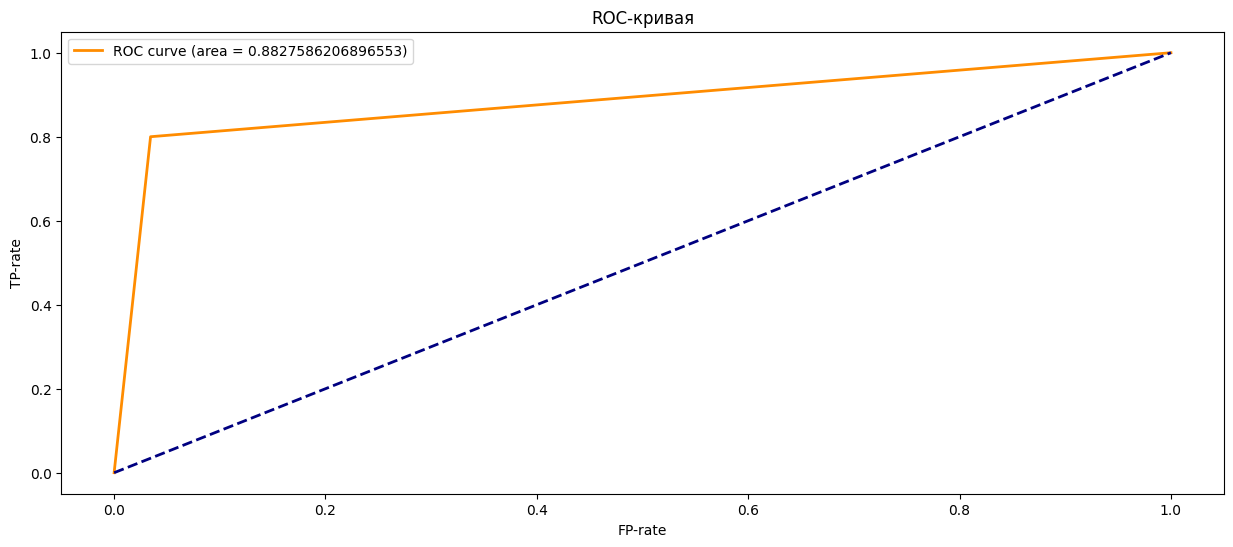

------------------------------------------------------------------------------------------------
SVC()
Accuracy: 0.5918367346938775
Precision: 0.35027072053311115
Recall: 0.5918367346938775
Матрица ошибок: [[[ 0 40]
  [ 0 58]]

 [[58  0]
  [40  0]]]
Лучшие параметры RandomSearchCV:  {'gamma': 'auto', 'C': 0.1}
Лучший результат для RandomSearchCV:  0.6923076923076923


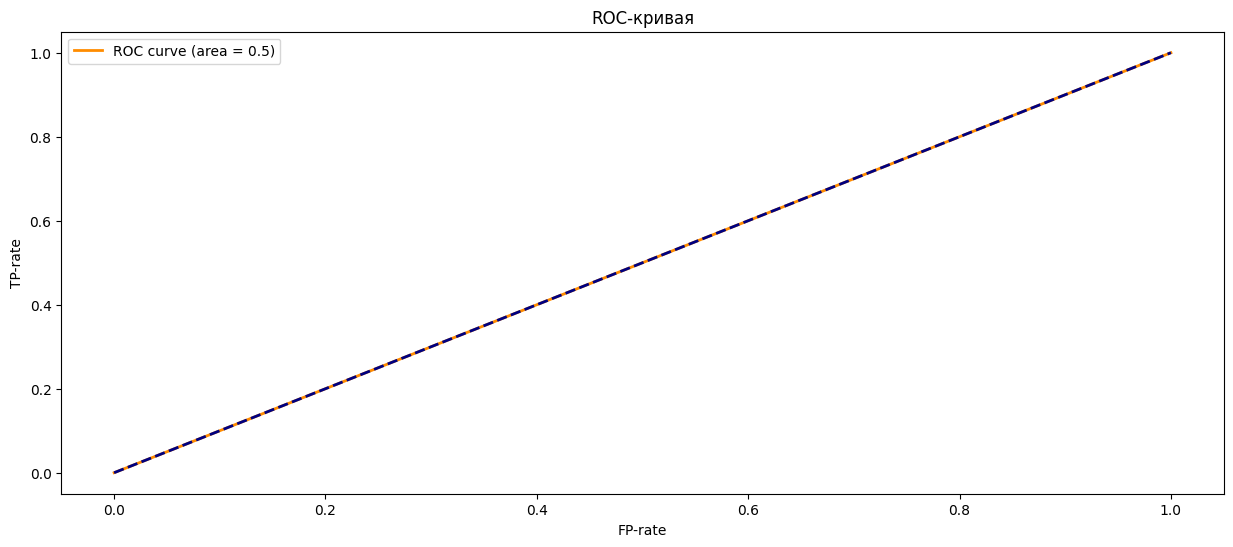

------------------------------------------------------------------------------------------------
DecisionTreeClassifier()
Accuracy: 0.8979591836734694
Precision: 0.9021851164708309
Recall: 0.8979591836734694
Матрица ошибок: [[[37  3]
  [ 7 51]]

 [[51  7]
  [ 3 37]]]
Лучшие параметры RandomSearchCV:  {'max_depth': 3}
Лучший результат для RandomSearchCV:  0.9435897435897436


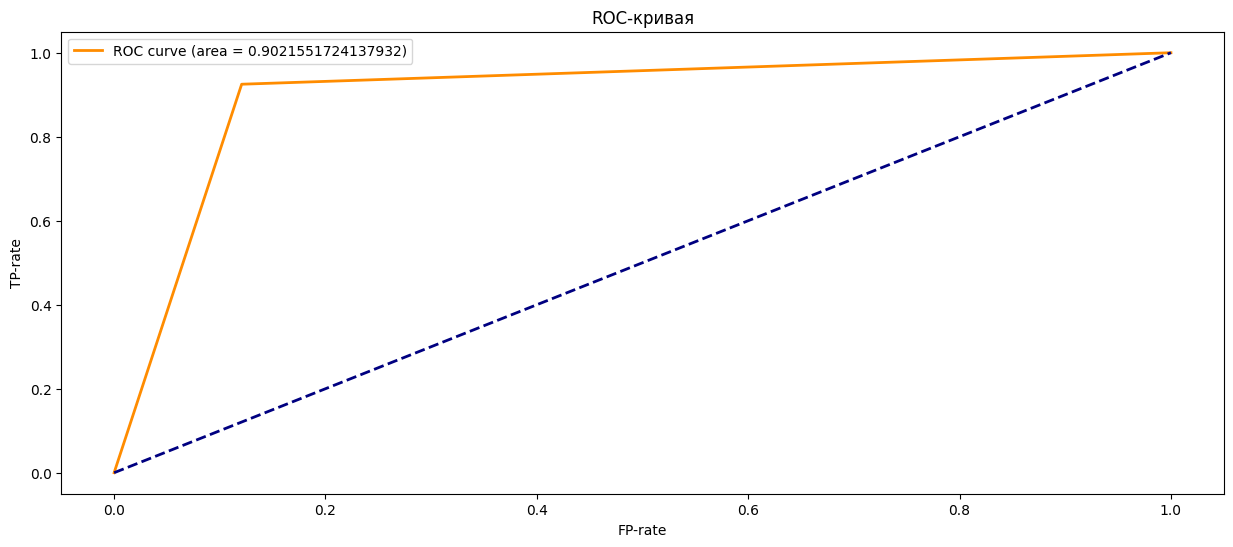

Feature Importance:
id: 0.026240553612298583
radius_mean: 0.0
texture_mean: 0.0
perimeter_mean: 0.0
area_mean: 0.011910331384015612
smoothness_mean: 0.0
compactness_mean: 0.0
concavity_mean: 0.0
concave points_mean: 0.0
symmetry_mean: 0.0
fractal_dimension_mean: 0.0
radius_se: 0.0
texture_se: 0.0
perimeter_se: 0.017195767195767195
area_se: 0.04552028218694885
smoothness_se: 0.0038673306837670425
compactness_se: 0.0
concavity_se: 0.0
concave points_se: 0.0
symmetry_se: 0.0
fractal_dimension_se: 0.01986744639376215
radius_worst: 0.0
texture_worst: 0.04877802973041061
perimeter_worst: 0.7146973019721107
area_worst: 0.0
smoothness_worst: 0.011608499335989501
compactness_worst: 0.0
concavity_worst: 0.0
concave points_worst: 0.08058802585239355
symmetry_worst: 0.011701740294511362
fractal_dimension_worst: 0.008024691358024692


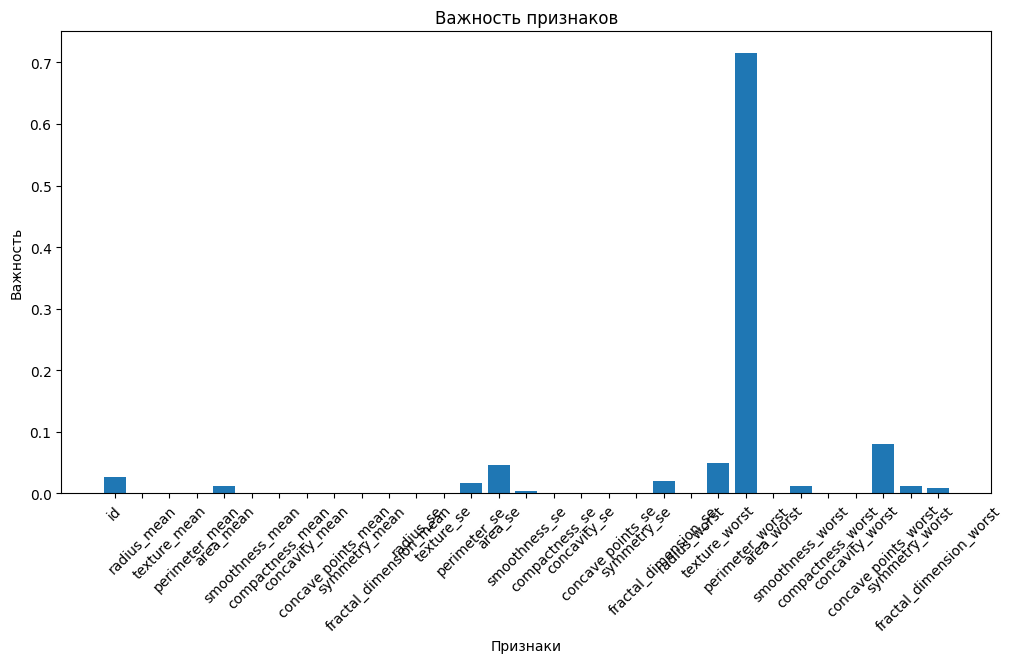

------------------------------------------------------------------------------------------------
RandomForestClassifier()
Accuracy: 0.9693877551020408
Precision: 0.9694720130555481
Recall: 0.9693877551020408
Матрица ошибок: [[[38  2]
  [ 1 57]]

 [[57  1]
  [ 2 38]]]
Лучшие параметры RandomSearchCV:  {'n_estimators': 50}
Лучший результат для RandomSearchCV:  0.9589743589743589


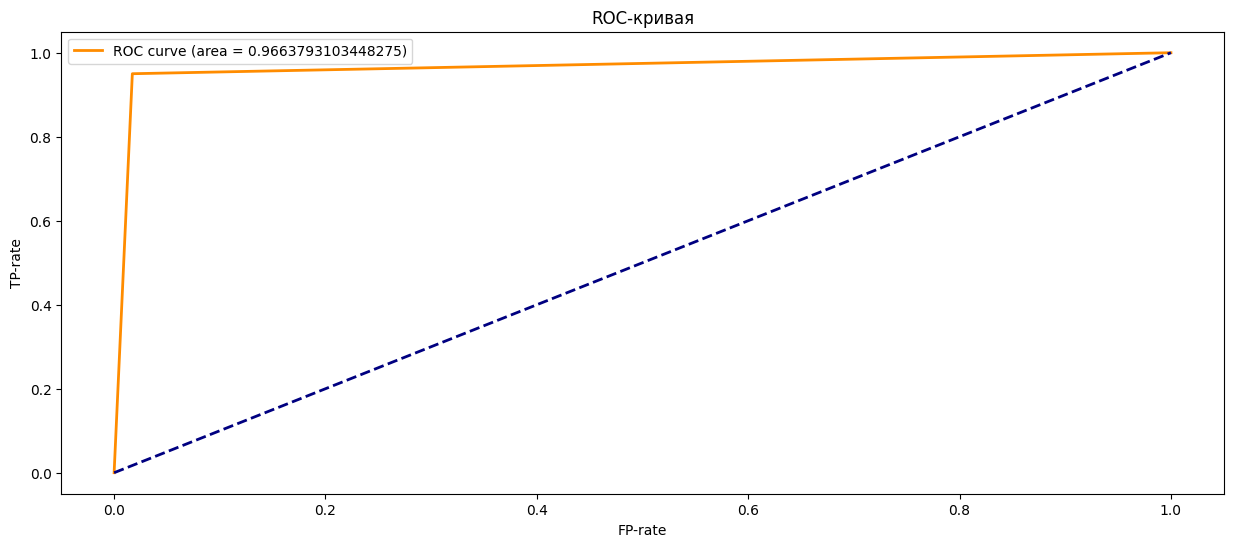

Feature Importance:
id: 0.0065767350461847125
radius_mean: 0.04561827239544401
texture_mean: 0.01854485975201215
perimeter_mean: 0.034883199128253266
area_mean: 0.05092278202563164
smoothness_mean: 0.00827790504938005
compactness_mean: 0.01631475122869722
concavity_mean: 0.08896847202573319
concave points_mean: 0.0688229548918406
symmetry_mean: 0.0026985795762549114
fractal_dimension_mean: 0.0036109220314196814
radius_se: 0.01053994046677761
texture_se: 0.003930058355428719
perimeter_se: 0.018359930950166345
area_se: 0.04536337259913024
smoothness_se: 0.00588793462187804
compactness_se: 0.004435340885069685
concavity_se: 0.004287536784187555
concave points_se: 0.003230885702574762
symmetry_se: 0.0042524091347068355
fractal_dimension_se: 0.005909543110676559
radius_worst: 0.12295998299776263
texture_worst: 0.016401187537441228
perimeter_worst: 0.08722695438367246
area_worst: 0.12433758871369302
smoothness_worst: 0.016238143361732075
compactness_worst: 0.009424733245913638
concavity_wors

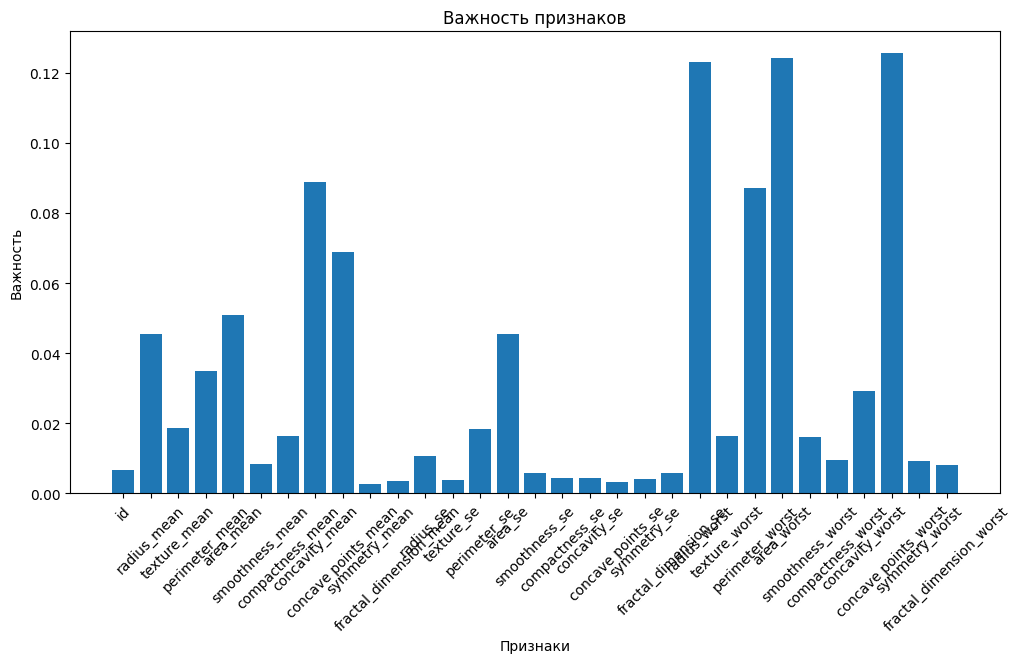

------------------------------------------------------------------------------------------------
GradientBoostingClassifier()
Accuracy: 0.9693877551020408
Precision: 0.9694720130555481
Recall: 0.9693877551020408
Матрица ошибок: [[[38  2]
  [ 1 57]]

 [[57  1]
  [ 2 38]]]
Лучшие параметры RandomSearchCV:  {'learning_rate': 0.5}
Лучший результат для RandomSearchCV:  0.9589743589743591


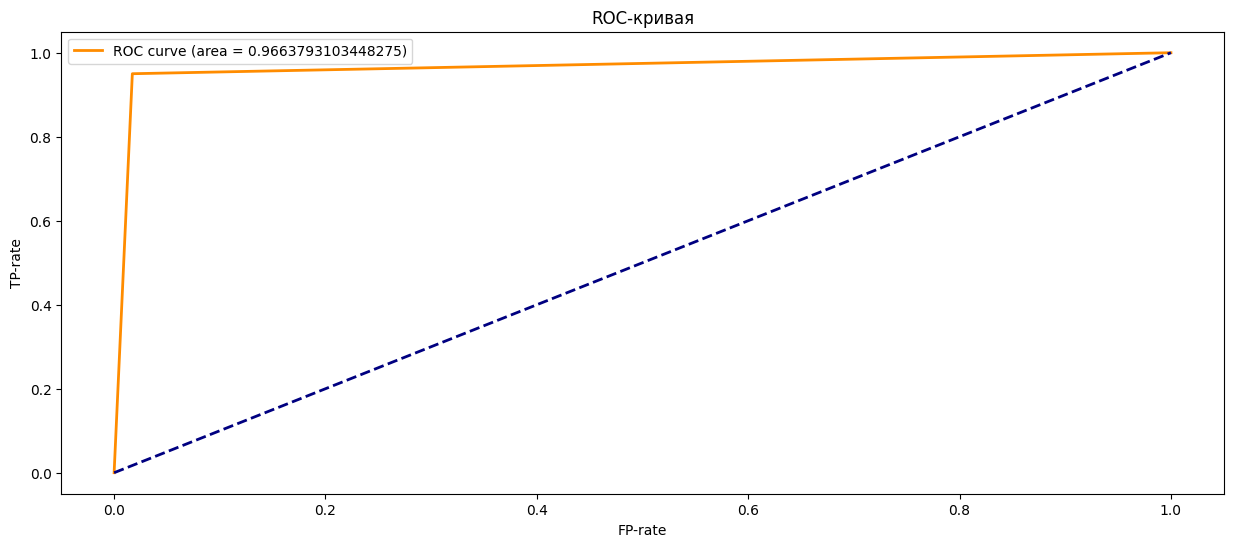

Feature Importance:
id: 0.003328795788893606
radius_mean: 7.808875901509378e-05
texture_mean: 0.016834512260870613
perimeter_mean: 7.626340432981903e-05
area_mean: 0.00518962955154951
smoothness_mean: 0.0001256288942003046
compactness_mean: 0.00856189386049198
concavity_mean: 0.002384416505749603
concave points_mean: 0.021799401230754297
symmetry_mean: 1.2558338410218538e-06
fractal_dimension_mean: 0.0003976997182507314
radius_se: 0.000809810413700255
texture_se: 0.0003921891815426048
perimeter_se: 0.0020569195466879323
area_se: 0.01724303696169665
smoothness_se: 0.0022960455496531863
compactness_se: 0.003273926713876559
concavity_se: 0.008288866675049177
concave points_se: 7.295888000836856e-05
symmetry_se: 0.002295878723838334
fractal_dimension_se: 0.006826406805043444
radius_worst: 0.05185184741262758
texture_worst: 0.06277011440248573
perimeter_worst: 0.22850716918173059
area_worst: 0.43858742937554046
smoothness_worst: 0.014920945362047635
compactness_worst: 0.0001296823790048279


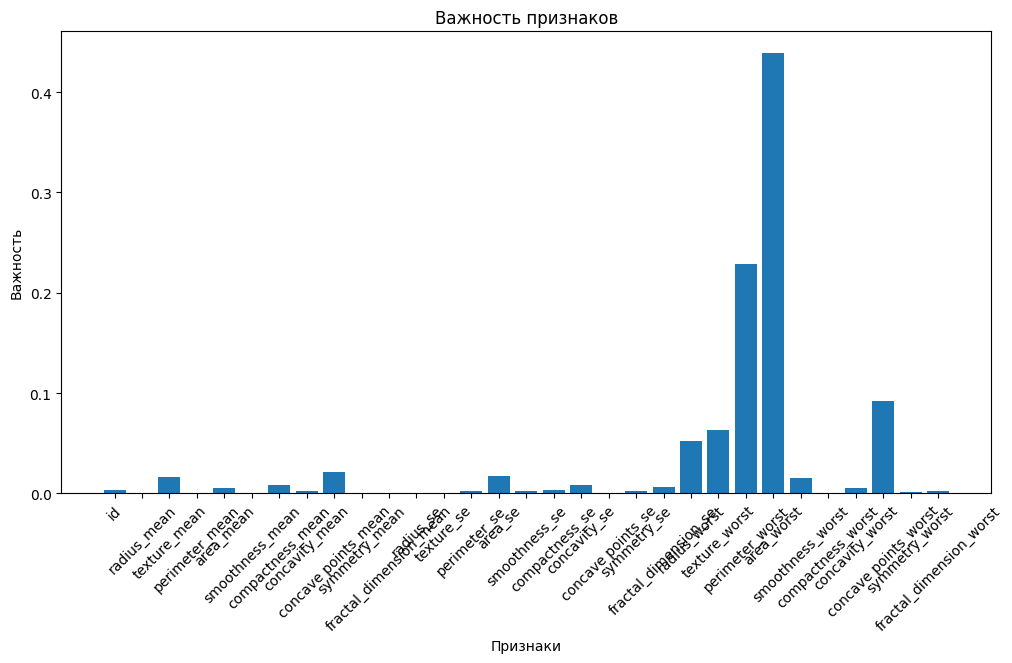

------------------------------------------------------------------------------------------------


In [ ]:
models = [LogisticRegression(), SVC(), DecisionTreeClassifier(), RandomForestClassifier(), GradientBoostingClassifier()]

function(models, X, y, multiclass=False)

## Задача 4. Спам-фильтрация для текстовых сообщений


+ Набор данных: SMS Spam Collection на Kaggle.
+ Предварительная обработка: векторизация текста, масштабирование, разделение данных на обучающие и тестовые.
+ Модели: логистическая регрессия, SVM, случайный лес, градиентный бустинг.
+ Сравнение моделей: точность, матрица ошибок, ROC-кривые.
+ Изучение и подбор гиперпараметров: GridSearchCV или RandomizedSearchCV.
+ Визуализация: важности признаков.

In [ ]:
df_sms = pd.read_csv(r'Datasets\sms.zip', encoding='latin1').dropna(axis=1)

df_sms.head(7)

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...


In [ ]:
df_sms.isna().sum()

v1    0
v2    0
dtype: int64

In [ ]:
df_sms = df_sms.rename(columns={'v1': 'is_spam', 'v2': 'message'})

In [ ]:
df_sms['is_spam'] = df_sms['is_spam'].str.strip()
df_sms['is_spam_bin'] = [1 if sms == 'spam' else 0 for sms in df_sms['is_spam']]

df_sms.head(7)

,is_spam,message,is_spam_bin
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0
5,spam,FreeMsg Hey there darling it's been 3 week's n...,1
6,ham,Even my brother is not like to speak with me. ...,0


In [ ]:
X, y = df_sms['message'], df_sms['is_spam_bin']

tfidf = TfidfVectorizer()
X_vectorized = tfidf.fit_transform(X)

LogisticRegression()
Accuracy: 0.9632286995515695
Precision: 0.9647273310807798
Recall: 0.9632286995515695
Матрица ошибок: [[[109  41]
  [  0 965]]

 [[965   0]
  [ 41 109]]]
Лучшие параметры RandomSearchCV:  {'warm_start': False, 'solver': 'lbfgs', 'max_iter': 200, 'C': 1}
Лучший результат для RandomSearchCV:  0.9573691574438958


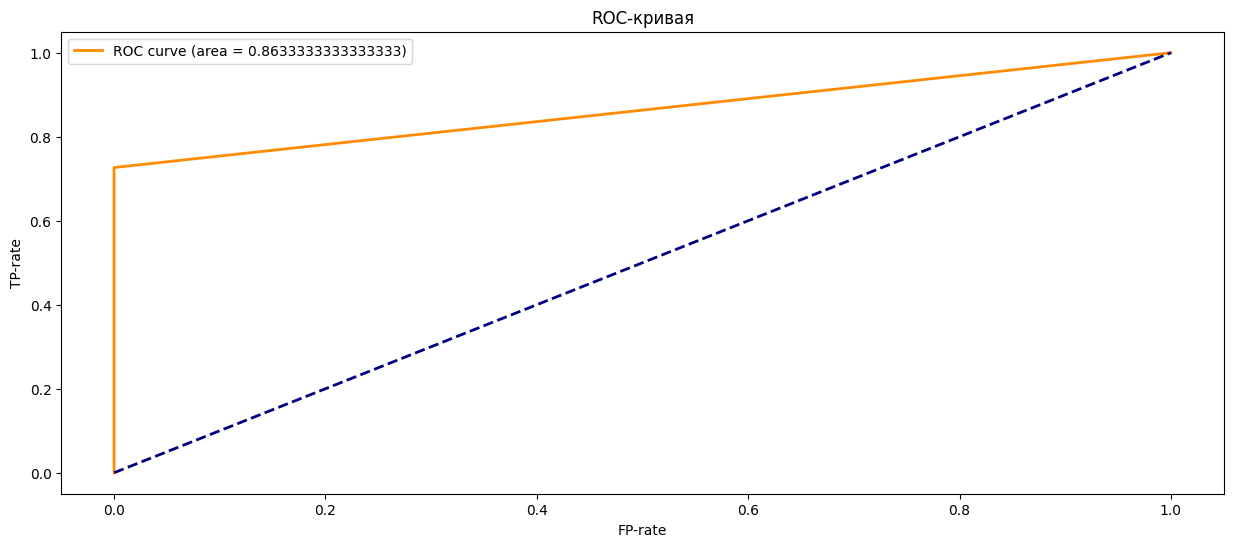

------------------------------------------------------------------------------------------------
SVC()
Accuracy: 0.9766816143497757
Precision: 0.9772933984334345
Recall: 0.9766816143497757
Матрица ошибок: [[[124  26]
  [  0 965]]

 [[965   0]
  [ 26 124]]]
Лучшие параметры RandomSearchCV:  {'gamma': 'auto', 'C': 0.1}
Лучший результат для RandomSearchCV:  0.8660536606724948


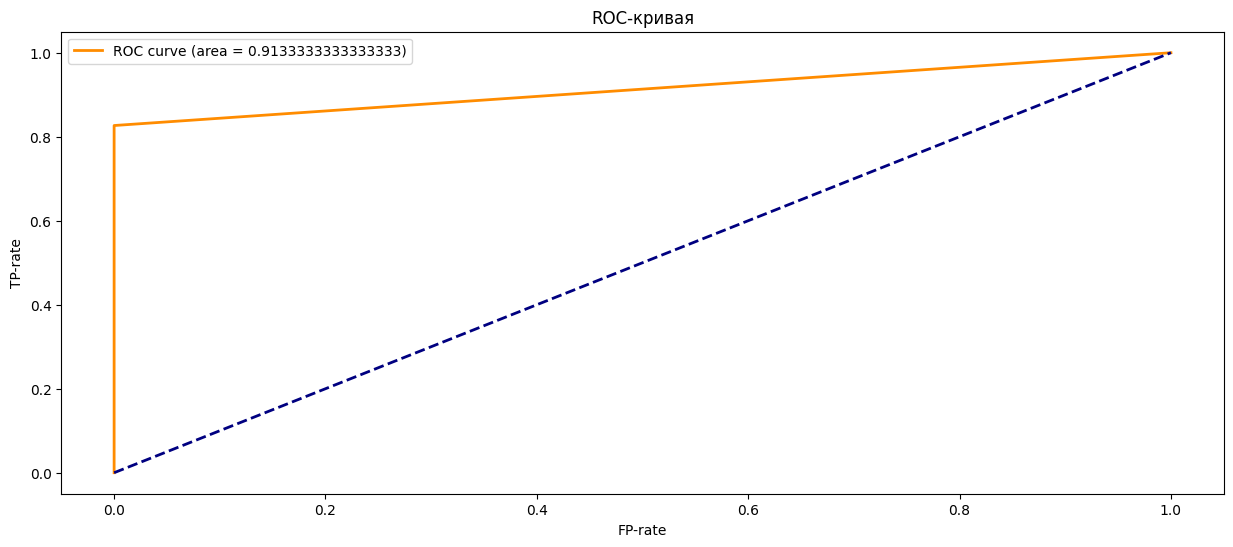

------------------------------------------------------------------------------------------------
RandomForestClassifier()
Accuracy: 0.9757847533632287
Precision: 0.9764438376970924
Recall: 0.9757847533632287
Матрица ошибок: [[[123  27]
  [  0 965]]

 [[965   0]
  [ 27 123]]]
Лучшие параметры RandomSearchCV:  {'n_estimators': 150}
Лучший результат для RandomSearchCV:  0.97576663495946


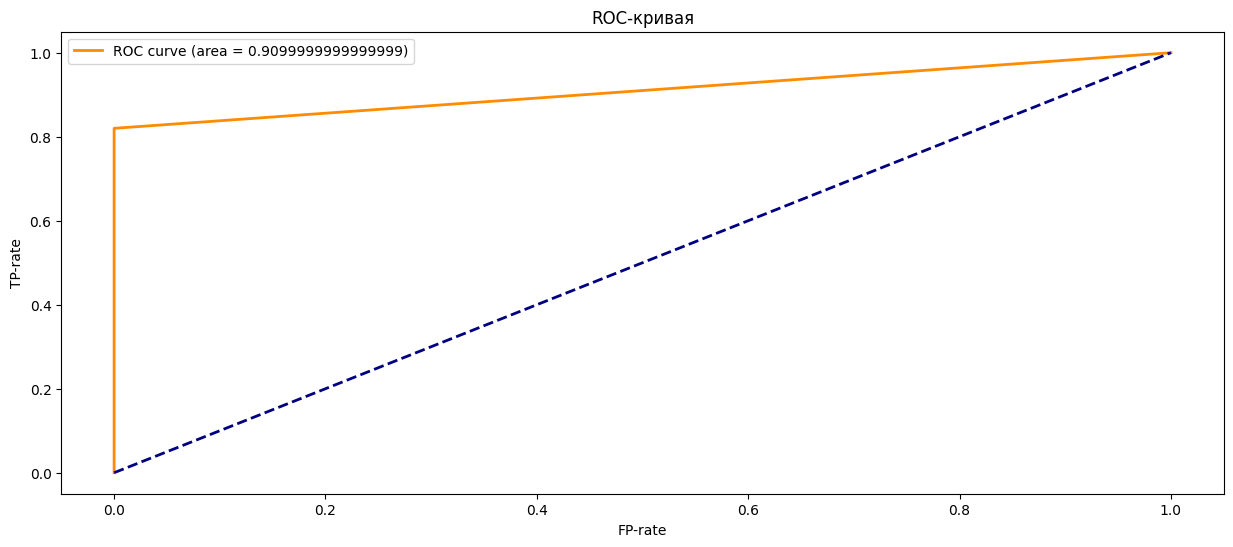

------------------------------------------------------------------------------------------------
GradientBoostingClassifier()
Accuracy: 0.9739910313901345
Precision: 0.9747498443576257
Recall: 0.9739910313901345
Матрица ошибок: [[[121  29]
  [  0 965]]

 [[965   0]
  [ 29 121]]]
Лучшие параметры RandomSearchCV:  {'learning_rate': 0.5}
Лучший результат для RandomSearchCV:  0.9748685157504291


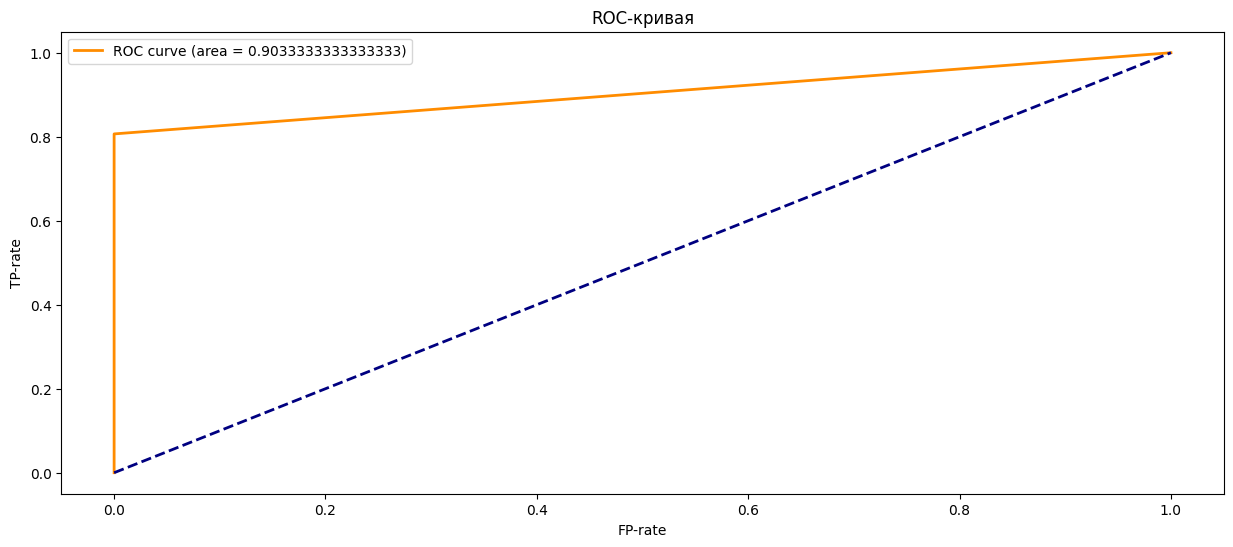

------------------------------------------------------------------------------------------------


In [ ]:
models = [LogisticRegression(), SVC(), RandomForestClassifier(), GradientBoostingClassifier()]

function(models, X_vectorized, y, multiclass=False, is_feature_importances=False)

## Задача 5. Классификация новостных статей
+ Набор данных: 20 Newsgroups dataset на sklearn.
+ Предварительная обработка: векторизация текста/TF-IDF, масштабирование, разделение данных на обучающие и тестовые.
+ Модели: логистическая регрессия, SVM, случайный лес, градиентный бустинг.
+ Сравнение моделей: точность, матрица ошибок, ROC-кривые.
+ Изучение и подбор гиперпараметров: GridSearchCV или RandomizedSearchCV.
+ Визуализация: важности признаков.

In [ ]:
newsgroups_data = fetch_20newsgroups(subset='all', shuffle=True, random_state=42)

df_news = pd.DataFrame(data=newsgroups_data.data, columns=['text'])
df_news['target'] = newsgroups_data.target

df_news = df_news.sample(2000).reset_index().drop(columns='index')

df_news.head(7)

,text,target
0,From: moret@masi.ibp.fr (Moret Yan - Magistere...,2
1,From: sunder@grusin.crhc.uiuc.edu (Srinivas Su...,17
2,From: joachim@kih.no (joachim lous)\nSubject: ...,1
3,From: mre@teal.Eng.Sun.COM (Mike Eisler)\nSubj...,10
4,From: VB30@lafibm.lafayette.edu (VB30)\nSubjec...,9
5,From: bill@scorch.apana.org.au (Bill Dowding)\...,13
6,From: timbol@netcom.com (Mike Timbol)\nSubject...,2


In [ ]:
df_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2000 non-null   object
 1   target  2000 non-null   int32 
dtypes: int32(1), object(1)
memory usage: 23.6+ KB


In [ ]:
X, y = df_news['text'], df_news['target']

X_vectorized = tfidf.fit_transform(X)

In [ ]:
models = [LogisticRegression(), SVC(), RandomForestClassifier(), GradientBoostingClassifier()]

function(models, X_vectorized, y, is_feature_importances=False, is_confusion_matrix=False, multiclass=True)

LogisticRegression()
Accuracy: 0.73
Precision: 0.7997067344377328
Recall: 0.73
Лучшие параметры RandomSearchCV:  {'warm_start': False, 'solver': 'liblinear', 'max_iter': 200, 'C': 1}
Лучший результат для RandomSearchCV:  0.6975
------------------------------------------------------------------------------------------------
SVC()
Accuracy: 0.66
Precision: 0.7993704724516745
Recall: 0.66
Лучшие параметры RandomSearchCV:  {'gamma': 'auto', 'C': 0.1}
Лучший результат для RandomSearchCV:  0.063125
------------------------------------------------------------------------------------------------
RandomForestClassifier()
Accuracy: 0.675
Precision: 0.7047146207769751
Recall: 0.675
Лучшие параметры RandomSearchCV:  {'n_estimators': 150}
Лучший результат для RandomSearchCV:  0.6937500000000001
------------------------------------------------------------------------------------------------
GradientBoostingClassifier()
Accuracy: 0.6825
Precision: 0.7316920007237345
Recall: 0.6825


KeyboardInterrupt: 

## Задача 6. Определение типа стекла.
+ Набор данных: Glass Identification Dataset на UCI Machine Learning.
+ Предварительная обработка: масштабирование, разделение данных на обучающие и тестовые.
+ Модели: логистическая регрессия, SVM, k-ближайших соседей, случайный лес, градиентный бустинг.
+ Сравнение моделей: точность, матрица ошибок.
+ Изучение и подбор гиперпараметров: GridSearchCV или RandomizedSearchCV.
+ Визуализация: важности признаков, корреляционная матрица.

In [ ]:
glass_identification = fetch_ucirepo(id=42) 

X = glass_identification.data.features 
y = glass_identification.data.targets 
df = pd.DataFrame(data = X, columns = glass_identification.data.feature_names)
df['target'] = y

df.head(7)

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,target
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.00,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.00,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.00,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.00,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.00,1
5,1.51596,12.79,3.61,1.62,72.97,0.64,8.07,0.0,0.26,1
6,1.51743,13.30,3.60,1.14,73.09,0.58,8.17,0.0,0.00,1


In [ ]:
y

,Type_of_glass
0,1
1,1
2,1
3,1
4,1
...,...
209,7
210,7
211,7
212,7


LogisticRegression()
Accuracy: 0.7209302325581395
Precision: 0.6393512851897185
Лучшие параметры RandomSearchCV:  {'warm_start': False, 'solver': 'liblinear', 'max_iter': 100, 'C': 1}
Лучший результат для RandomSearchCV:  0.5673949579831933
------------------------------------------------------------------------------------------------
SVC()
Accuracy: 0.32558139534883723
Precision: 0.10600324499729584
Лучшие параметры RandomSearchCV:  {'gamma': 'auto', 'C': 1}
Лучший результат для RandomSearchCV:  0.6495798319327731
------------------------------------------------------------------------------------------------
KNeighborsClassifier()
Accuracy: 0.6511627906976745
Precision: 0.6767913933611608
Лучшие параметры RandomSearchCV:  {'weights': 'distance', 'n_neighbors': 3, 'algorithm': 'auto'}
Лучший результат для RandomSearchCV:  0.6436974789915967
------------------------------------------------------------------------------------------------
RandomForestClassifier()
Accuracy: 0.86046511627

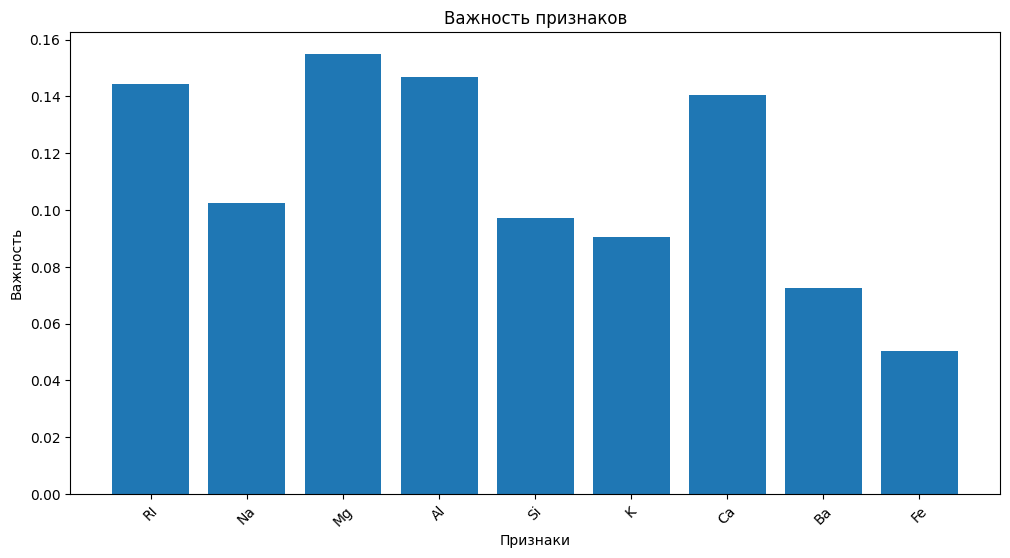

------------------------------------------------------------------------------------------------
GradientBoostingClassifier()
Accuracy: 0.8604651162790697
Precision: 0.8799372462163159
Лучшие параметры RandomSearchCV:  {'learning_rate': 0.5}
Лучший результат для RandomSearchCV:  0.7485714285714286
Feature Importance:
RI: 0.15875416859456784
Na: 0.050689134228349704
Mg: 0.15881911527613288
Al: 0.16906753914647113
Si: 0.06979668298477147
K: 0.03644972696142498
Ca: 0.16646925520946063
Ba: 0.13332464901544913
Fe: 0.05662972858337217


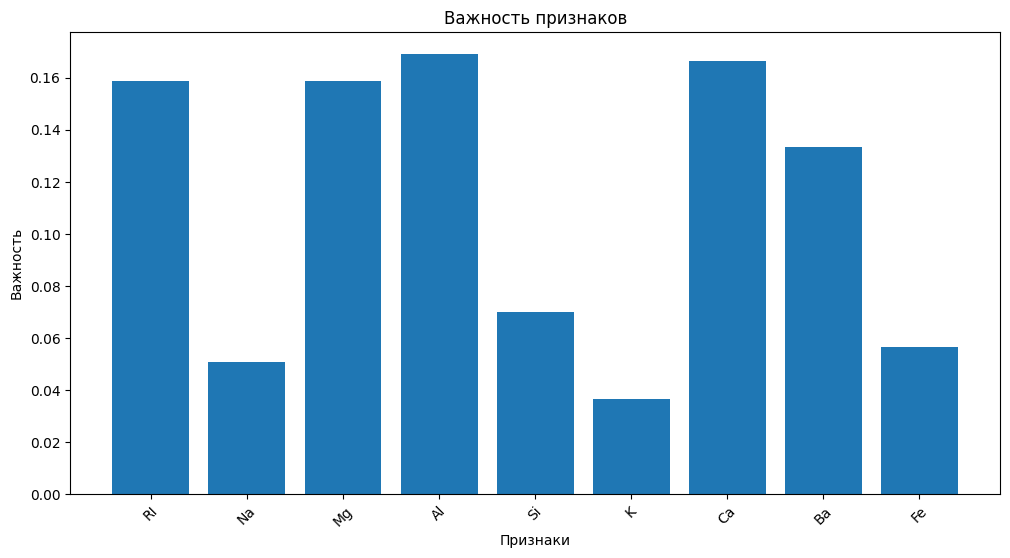

------------------------------------------------------------------------------------------------


In [ ]:
X_scaled = MinMaxScaler().fit_transform(X, y)
X, y = df.drop(columns='target'), df.target

models = [LogisticRegression(), SVC(), KNeighborsClassifier(), RandomForestClassifier(), GradientBoostingClassifier()]

function(models, X, y, is_recall=False, multiclass=True, is_confusion_matrix=False)

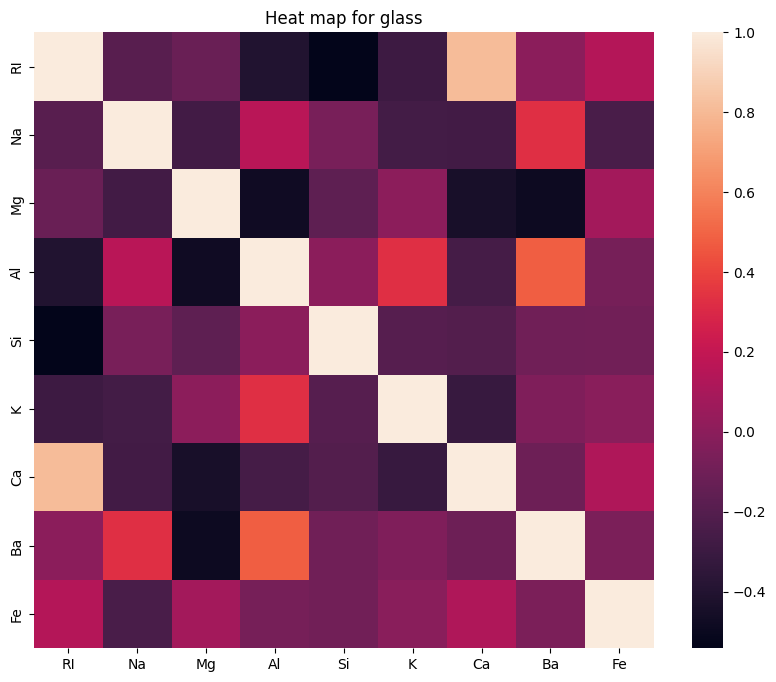

In [ ]:
plt.figure(figsize=(10,8))   

sns.heatmap(X.corr())

plt.title('Heat map for glass')
plt.show()